# <b>CS156 (Introduction to AI), Fall 2022</b>
# <u><b>Homework 9 submission</b></u>

### Roster Name: Rohan Athalye
### Student ID: 014099982
### Email address: rohan.athalye@sjsu.edu

##  <u>References and sources </u>

Autoencoders.MNIST.ipynb from Canvas under Files/Example Jupyter Notebooks

##  <u>Solution</u>

#### Load libraries and set random number generator seed

In [49]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPool2D, UpSampling2D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [50]:
np.random.seed(42)

#### Code the solution

#### Load and prepare the image data

In [51]:
# Loads the dataset and splits the data into training, validation, and test sets.
(x_train_valid, y_train_valid), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train, x_validation, y_train, y_validation = train_test_split(x_train_valid, y_train_valid, test_size=0.2, random_state=0)

# Scales the images to the [0, 1] range.
x_train = x_train.astype("float32") / 255
x_validation = x_validation.astype("float32") / 255
x_test = x_test.astype("float32") / 255

x_train.shape, x_validation.shape, x_test.shape

((48000, 28, 28), (12000, 28, 28), (10000, 28, 28))

#### Create an autoencoder model for encoding and decoding images

In [52]:
# Flattens the image data into a single dense input vector of size 784.
x_train = x_train.reshape(-1, 784)
x_validation = x_validation.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

x_train.shape, x_validation.shape, x_test.shape

((48000, 784), (12000, 784), (10000, 784))

In [53]:
input_layer = Input(shape=(784,))

encoded = layers.Dense(128, activation='relu')(input_layer)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(784, activation='sigmoid')(decoded)

# Reconstruction model.
autoencoder = keras.Model(input_layer, decoded)

# Encoder model.
encoder = keras.Model(input_layer, encoded)

# Decoder model.
encoded_input = keras.Input(shape=(128,))
decoder_layer = autoencoder.layers[-1]  # Last layer of the autoencoder model.
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

autoencoder.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 784)]             0         
                                                                 
 dense_24 (Dense)            (None, 128)               100480    
                                                                 
 dense_25 (Dense)            (None, 64)                8256      
                                                                 
 dense_26 (Dense)            (None, 32)                2080      
                                                                 
 dense_27 (Dense)            (None, 64)                2112      
                                                                 
 dense_28 (Dense)            (None, 128)               8320      
                                                                 
 dense_29 (Dense)            (None, 784)               101

#### Train the autoencoder model

In [54]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=30,
                batch_size=2048,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/30
24/24 [==============================] - 1s 21ms/step - loss: 0.5990 - val_loss: 0.5058
Epoch 2/30
24/24 [==============================] - 0s 12ms/step - loss: 0.4598 - val_loss: 0.4202
Epoch 3/30
24/24 [==============================] - 0s 12ms/step - loss: 0.3979 - val_loss: 0.3794
Epoch 4/30
24/24 [==============================] - 0s 12ms/step - loss: 0.3678 - val_loss: 0.3590
Epoch 5/30
24/24 [==============================] - 0s 13ms/step - loss: 0.3493 - val_loss: 0.3419
Epoch 6/30
24/24 [==============================] - 0s 14ms/step - loss: 0.3348 - val_loss: 0.3304
Epoch 7/30
24/24 [==============================] - 0s 13ms/step - loss: 0.3261 - val_loss: 0.3248
Epoch 8/30
24/24 [==============================] - 0s 13ms/step - loss: 0.3207 - val_loss: 0.3203
Epoch 9/30
24/24 [==============================] - 0s 12ms/step - loss: 0.3173 - val_loss: 0.3175
Epoch 10/30
24/24 [==============================] - 0s 13ms/step - loss: 0.3144 - val_loss: 0.3150
Epoch 11/

#### Show the original and reconstructed images for the first 10 images in the test set

313/313 [==============================] - 1s 2ms/step


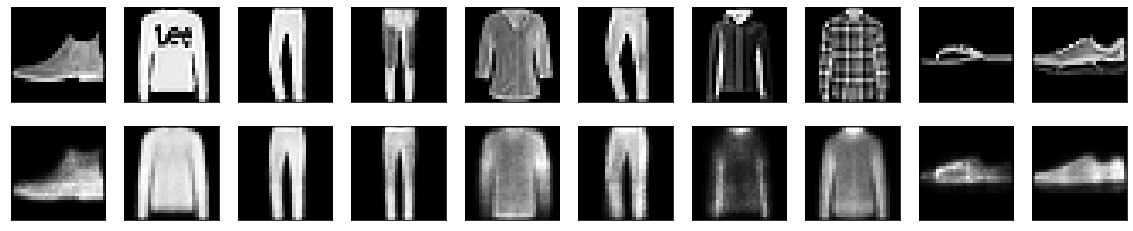

In [55]:
predictions = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original images.
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed images.
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predictions[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### Create an autoencoder model to denoise noisy images

In [56]:
# Reshapes the images to 2-D from the flattened shape.
x_train = x_train.reshape(-1, 28, 28, 1)
x_validation = x_validation.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

x_train.shape, x_validation.shape, x_test.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (10000, 28, 28, 1))

In [57]:
# Adds some noise to the training, validation, and test sets of images.
noise_factor = 0.4

x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_validation_noisy = x_validation + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_validation.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_validation_noisy = np.clip(x_validation_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [58]:
# 2 convolutional layers with max pooling in between for the encoder, with mirror architecture for the decoder.
input_layer = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_layer, decoded)
autoencoder.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_21 (Conv2D)          (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_22 (Conv2D)          (None, 7, 7, 32)          924

#### Train the autoencoder model

In [59]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train_noisy, x_train,
                epochs=30,
                batch_size=2048,
                shuffle=True,
                validation_data=(x_validation_noisy, x_validation))

Epoch 1/30
24/24 [==============================] - 3s 96ms/step - loss: 0.5699 - val_loss: 0.4009
Epoch 2/30
24/24 [==============================] - 2s 82ms/step - loss: 0.3627 - val_loss: 0.3406
Epoch 3/30
24/24 [==============================] - 2s 81ms/step - loss: 0.3308 - val_loss: 0.3227
Epoch 4/30
24/24 [==============================] - 2s 81ms/step - loss: 0.3191 - val_loss: 0.3155
Epoch 5/30
24/24 [==============================] - 2s 81ms/step - loss: 0.3137 - val_loss: 0.3114
Epoch 6/30
24/24 [==============================] - 2s 81ms/step - loss: 0.3103 - val_loss: 0.3086
Epoch 7/30
24/24 [==============================] - 2s 81ms/step - loss: 0.3079 - val_loss: 0.3065
Epoch 8/30
24/24 [==============================] - 2s 82ms/step - loss: 0.3057 - val_loss: 0.3044
Epoch 9/30
24/24 [==============================] - 2s 81ms/step - loss: 0.3040 - val_loss: 0.3042
Epoch 10/30
24/24 [==============================] - 2s 82ms/step - loss: 0.3025 - val_loss: 0.3021
Epoch 11/

#### Plot the noisy and denoised images for the first 10 images of the test set

313/313 [==============================] - 1s 2ms/step


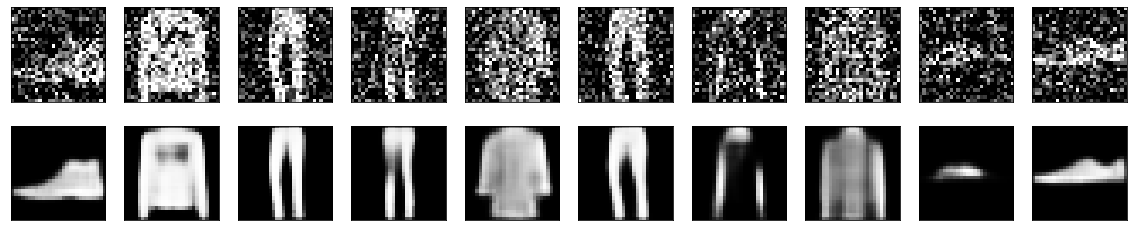

In [60]:
predictions = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Noisy images.
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed images.
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predictions[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()